In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

/Users/vedkulkarni/Downloads/q/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/var/folders/c8/w5hvq5_962z6tb1g4c6qfhtc0000gn/T/ipykernel_11724/1432649184.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:

# Function to get historical stock data
def get_stock_data(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    stock_data = stock.history(start=start_date, end=end_date)
    return stock_data

# Function to get options data
def get_options_data(ticker, expiration_date):
    stock = yf.Ticker(ticker)
    options_data = stock.option_chain(expiration_date)
    return options_data

# Function to calculate the delta of an option
def calculate_delta(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if option_type == 'call':
        delta = norm.cdf(d1)
    elif option_type == 'put':
        delta = norm.cdf(d1) - 1
    return delta


Explanation:
Import Libraries: We import essential Python libraries:

numpy for numerical operations.
pandas for data manipulation and analysis.
yfinance to fetch financial data from Yahoo Finance.
matplotlib and seaborn for plotting and visualization.
scipy.stats.norm to use the normal distribution, which helps in option pricing.
get_stock_data Function: This function retrieves historical stock data for a given ticker symbol between specified start and end dates using Yahoo Finance.

get_options_data Function: This function retrieves options data (contracts that allow buying or selling a stock at a specific price before a certain date) for a given ticker and expiration date.

calculate_delta Function: This function calculates the delta of an option.

Delta:

Delta measures how much the price of an option is expected to change for a $1 change in the price of the underlying stock.

For example, a delta of 0.5 means that if the stock price increases by $1, the option price is expected to increase by $0.50.

For call options (the right to buy a stock), delta ranges from 0 to 1.
For put options (the right to sell a stock), delta ranges from -1 to 0.
Black-Scholes Model:

The Black-Scholes model is a mathematical model used to estimate the price of European-style options.
It considers factors such as the current stock price (S), the option's strike price (K), time to expiration (T), risk-free interest rate (r), and the stock's volatility (sigma).
The formula for delta in the Black-Scholes model involves calculating d1, which is used to find the cumulative distribution function (CDF) of the normal distribution.
The delta is calculated using the following formula:

(insert formula)

For call options, delta = CDF(d1).
For put options, delta = CDF(d1) - 1.

In [3]:
# Enhanced delta hedging strategy with adjustments
def enhanced_delta_hedge(stock_data, atm_options, delta_threshold=0.01, risk_free_rate=0.01, transaction_cost=0.001, rebalance_frequency=5):
    if stock_data.empty:
        print("Error: Stock data is empty.")
        return pd.DataFrame()

    if atm_options.empty:
        print("Error: Options data is empty.")
        return pd.DataFrame()

    hedge_positions = []
    current_delta = 0
    portfolio_value = 1_000_000  # Initial portfolio value
    expiration_date_naive = pd.to_datetime(expiration_date).tz_localize(None)

    print(f"Initial Portfolio Value: {portfolio_value}")

    for i, (date, row) in enumerate(stock_data.iterrows()):
        if i % rebalance_frequency != 0:
            continue

        try:
            date_naive = date.tz_localize(None)  # Ensure the date is timezone-naive
            stock_price = row['Close']

            # Calculate implied volatility mean
            implied_volatility = atm_options['impliedVolatility'].mean()

            K = atm_options['strike'].mean()
            T = (expiration_date_naive - date_naive).days / 365.25
            if T < (1 / 365.25):
                T = 1 / 365.25
            option_type = 'call' if stock_price >= K else 'put'

            # Calculate predicted delta for each option and store in atm_options
            atm_options['predicted_delta'] = atm_options.apply(
                lambda x: calculate_delta(stock_price, x['strike'], T, risk_free_rate, x['impliedVolatility'], option_type), axis=1)

            predicted_delta = atm_options['predicted_delta'].mean()
            closest_option = atm_options.iloc[(atm_options['predicted_delta'] - current_delta).abs().argsort()[:1]]
            option_delta = closest_option['predicted_delta'].values[0]

            # Calculate the required change in delta
            delta_change = predicted_delta - current_delta
            transaction_cost_value = 0
            if abs(delta_change) > delta_threshold:
                # Apply transaction cost for rebalancing
                transaction_cost_value = transaction_cost * abs(delta_change) * stock_price
                portfolio_value -= transaction_cost_value

                # Adjust the portfolio gradually
                portfolio_value -= current_delta * stock_price  # Close the current position
                current_delta = predicted_delta  # Update to the new predicted delta
                portfolio_value += current_delta * stock_price  # Open the new position

            hedge_positions.append((date_naive, stock_price, portfolio_value, current_delta, delta_change, transaction_cost_value, implied_volatility, option_type))

            # Debugging output
            print(f"Date: {date_naive}, Stock Price: {stock_price}, Portfolio Value: {portfolio_value}, "
                  f"Current Delta: {current_delta}, Delta Change: {delta_change}, Transaction Cost: {transaction_cost_value}, "
                  f"Implied Volatility: {implied_volatility}, Option Type: {option_type}")

        except Exception as e:
            print(f"Error on {date_naive}: {str(e)}")
            break

    # Convert hedge positions to DataFrame for analysis
    enhanced_hedge_positions = pd.DataFrame(hedge_positions, columns=[
        'Date', 'Stock Price', 'Portfolio Value', 'Current Delta', 'Delta Change', 'Transaction Cost', 'Implied Volatility', 'Option Type'])

    print(f"Total hedge positions: {len(hedge_positions)}")
    return enhanced_hedge_positions


Explanation:
Function Definition: The enhanced_delta_hedge function aims to manage the risk of holding a stock by using options to hedge (offset) potential losses.

Hedging:

Hedging is a strategy used to reduce the risk of adverse price movements in an asset.
In the context of options, it involves taking an opposite position in a related security to offset potential losses.
Delta hedging specifically aims to make the portfolio delta-neutral, meaning the portfolio's value is not affected by small changes in the price of the underlying asset.
Input Checks: It checks if the provided stock data and options data are empty. If so, it returns an empty DataFrame and prints an error message.

Initial Setup:

hedge_positions stores the details of each hedging action.
current_delta keeps track of the current delta of the portfolio.
portfolio_value starts at $1,000,000.
expiration_date_naive converts the expiration date to a timezone-naive format.
Main Loop: Iterates through each date in the stock data:

Rebalance Frequency: Only rebalance every rebalance_frequency days.
Calculate Variables: Determine stock price, implied volatility, strike price, time to expiration, and option type.
Predict Delta: Calculate the delta for the options and determine the predicted delta for the portfolio.
Transaction Cost: Calculate and deduct transaction costs if the delta change exceeds the threshold.
Update Portfolio: Adjust the portfolio to match the new delta.
Store Results: Save the results of the hedging action.
Return Results: Convert the list of hedge positions to a DataFrame and return it.

Initial Portfolio Value: 1000000
Date: 2023-01-03 00:00:00, Stock Price: 124.04805755615234, Portfolio Value: 999938.3445808506, Current Delta: -0.4965319613825783, Delta Change: -0.4965319613825783, Transaction Cost: 0.06159382532405529, Implied Volatility: 1.0629770534179688, Option Type: put
Date: 2023-01-10 00:00:00, Stock Price: 129.66177368164062, Portfolio Value: 999940.0856218084, Current Delta: -0.4830909626052211, Delta Change: 0.013440998777357216, Transaction Cost: 0.0017427837415248998, Implied Volatility: 1.0629770534179688, Option Type: put
Date: 2023-01-18 00:00:00, Stock Price: 134.10519409179688, Portfolio Value: 999940.0856218084, Current Delta: -0.4830909626052211, Delta Change: 0.009598934444191243, Transaction Cost: 0, Implied Volatility: 1.0629770534179688, Option Type: put
Date: 2023-01-25 00:00:00, Stock Price: 140.7008514404297, Portfolio Value: 999943.615381725, Current Delta: -0.45797886716556696, Delta Change: 0.025112095439654147, Transaction Cost: 0.00353

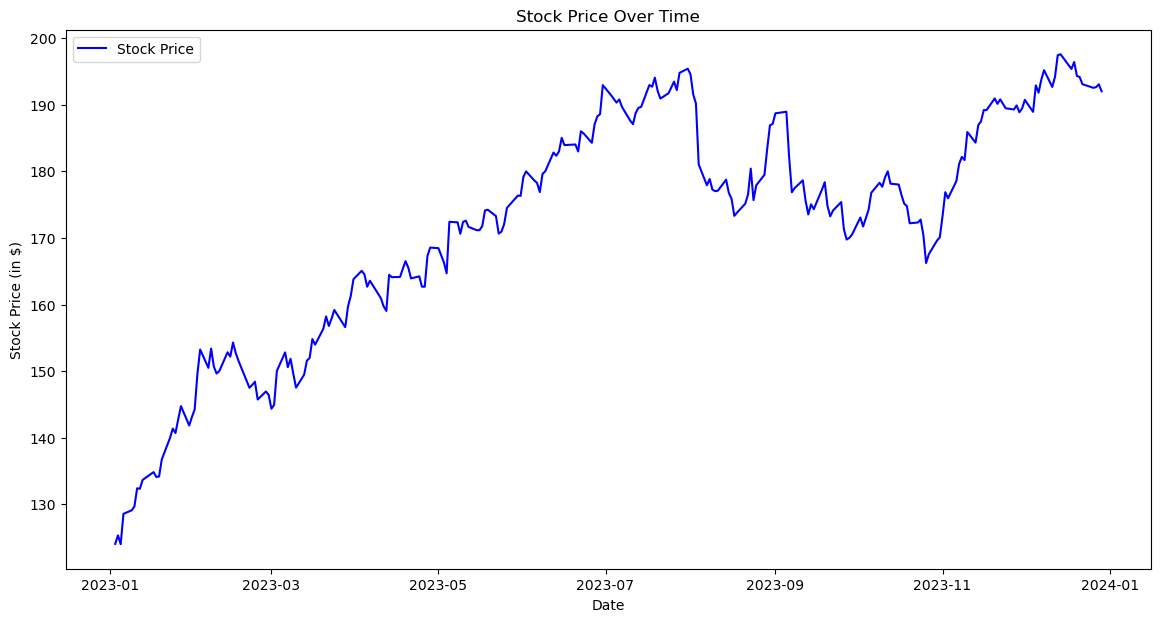

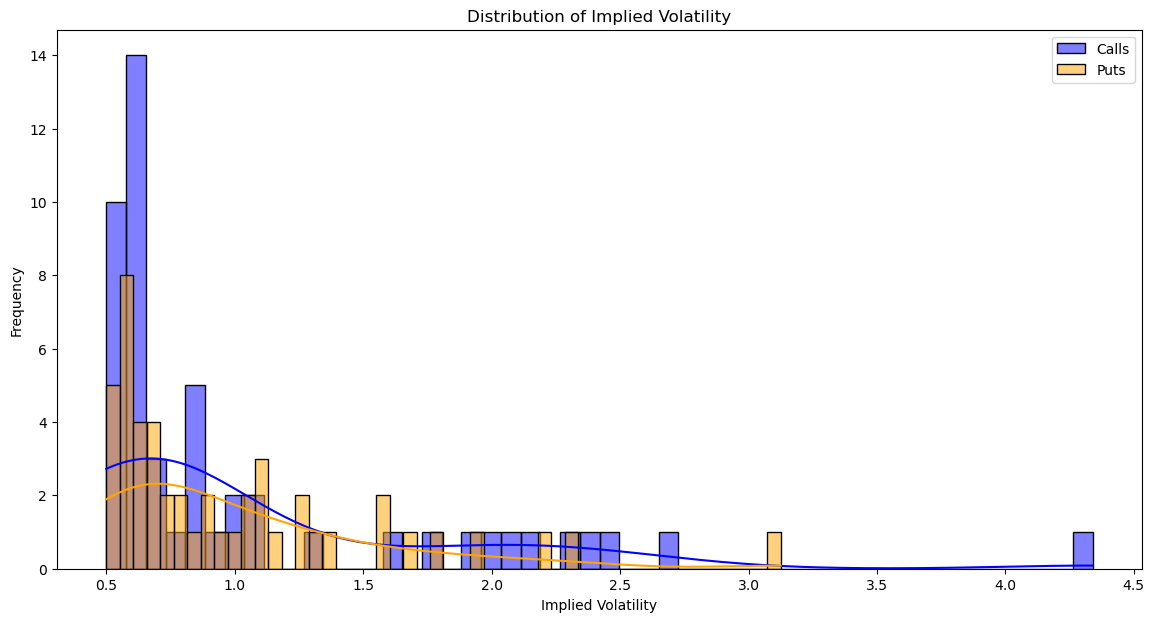

In [4]:
# Example ticker and dates
ticker = "AAPL"  # Example ticker
start_date = "2023-01-01"
end_date = "2024-01-01"
expiration_date = "2024-08-02"  # Using one of the available expiration dates

# Load stock and options data
stock_data = get_stock_data(ticker, start_date, end_date)
options_data = get_options_data(ticker, expiration_date)
atm_options = options_data.calls  # Example for ATM options, modify as needed

# Execute the enhanced delta hedging strategy
enhanced_hedge_positions = enhanced_delta_hedge(stock_data, atm_options, delta_threshold=0.01, risk_free_rate=0.01, transaction_cost=0.001, rebalance_frequency=5)

# Plotting stock price over time with enhancements
plt.figure(figsize=(14, 7))
sns.lineplot(x=stock_data.index, y=stock_data['Close'], label='Stock Price', color='blue')
plt.title('Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Stock Price (in $)')
plt.legend()
plt.show()

# Plot the distribution of implied volatility with enhancements
plt.figure(figsize=(14, 7))
sns.histplot(atm_options['impliedVolatility'], bins=50, kde=True, label='Calls', color='blue')
sns.histplot(options_data.puts['impliedVolatility'], bins=50, kde=True, label='Puts', color='orange')
plt.title('Distribution of Implied Volatility')
plt.xlabel('Implied Volatility')
plt.ylabel('Frequency')
plt.legend()
plt.show()


Explanation:
Define Parameters: Set the ticker symbol for Apple ("AAPL") and specify the start and end dates for the stock data. Also, set an expiration date for the options data.

Load Data:

stock_data: Fetch historical stock prices for Apple between the specified dates.
options_data: Fetch options data for Apple that expire on the specified date.
atm_options: Select at-the-money (ATM) options (where the strike price is close to the current stock price).
Execute Hedging Strategy: Run the enhanced_delta_hedge function using the loaded stock and options data. This will create a hedged portfolio and track its performance.

Plot Stock Prices: Create a line plot of Apple's stock price over time.

Plot Implied Volatility: Create histograms to show the distribution of implied volatility for call and put options. Implied volatility represents the market's expectation of how much the stock price will fluctuate.

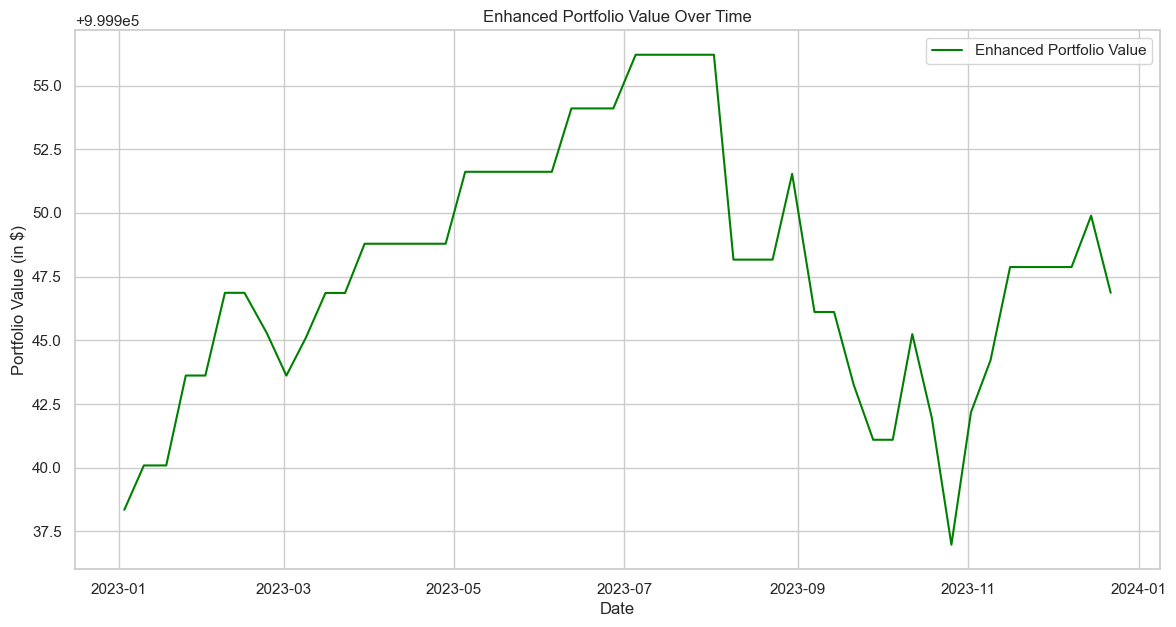

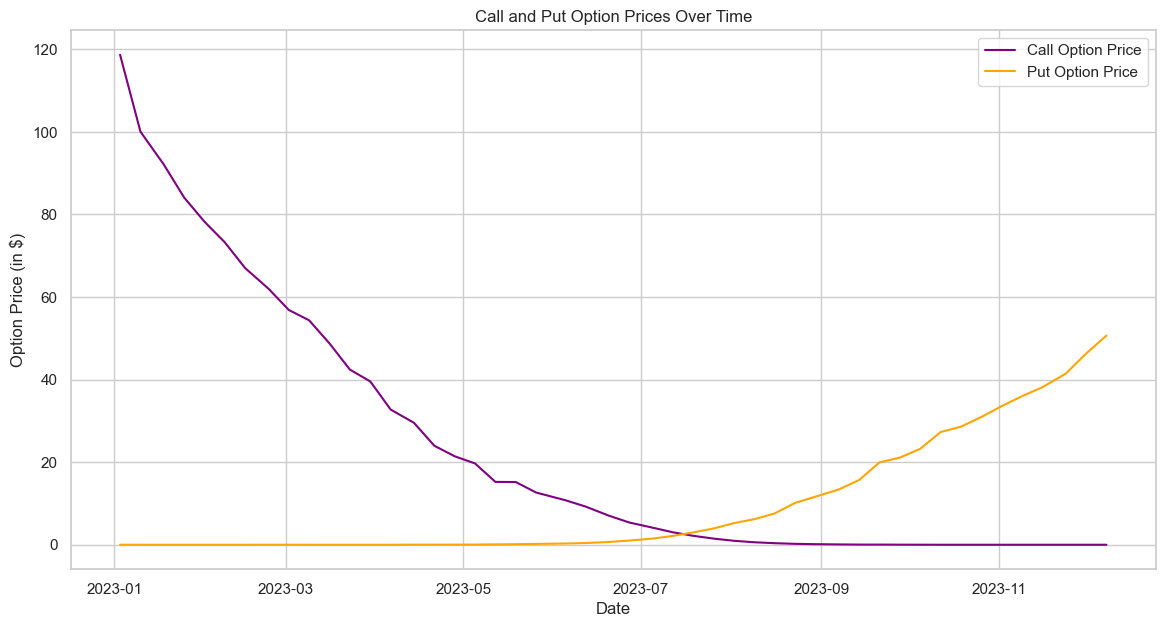

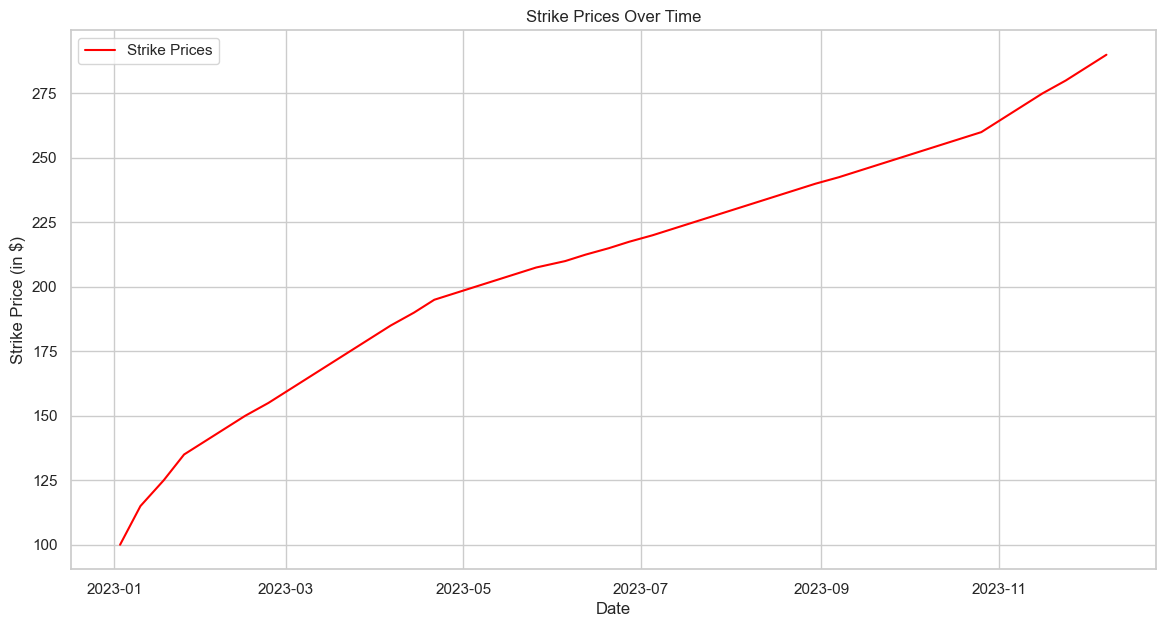

      Date  Transaction Cost
2023-01-03          0.061594
2023-01-10          0.001743
2023-01-18          0.000000
2023-01-25          0.003533
2023-02-01          0.000000
2023-02-08          0.003250
2023-02-15          0.000000
2023-02-23          0.001580
2023-03-02          0.001667
2023-03-09          0.001496
2023-03-16          0.001751
2023-03-23          0.000000
2023-03-30          0.001934
2023-04-06          0.000000
2023-04-14          0.000000
2023-04-21          0.000000
2023-04-28          0.000000
2023-05-05          0.002827
2023-05-12          0.000000
2023-05-19          0.000000
2023-05-26          0.000000
2023-06-05          0.000000
2023-06-12          0.002491
2023-06-20          0.000000
2023-06-27          0.000000
2023-07-05          0.002109
2023-07-12          0.000000
2023-07-19          0.000000
2023-07-26          0.000000
2023-08-02          0.000000
2023-08-09          0.008035
2023-08-16          0.000000
2023-08-23          0.000000
2023-08-30    

In [5]:
# Plotting the enhanced portfolio value with enhancements
if not enhanced_hedge_positions.empty:
    sns.set(style="whitegrid")

    plt.figure(figsize=(14, 7))
    sns.lineplot(x='Date', y='Portfolio Value', data=enhanced_hedge_positions, label='Enhanced Portfolio Value', color='green')
    plt.title('Enhanced Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (in $)')
    plt.legend()
    plt.show()

    # Ensure lengths match for call and put option prices
    min_length = min(len(enhanced_hedge_positions), len(atm_options), len(options_data.puts))
    dates = enhanced_hedge_positions['Date'].iloc[:min_length]
    call_prices = atm_options['lastPrice'].iloc[:min_length]
    put_prices = options_data.puts['lastPrice'].iloc[:min_length]
    strike_prices = atm_options['strike'].iloc[:min_length]

    # Plotting call and put option prices over time
    plt.figure(figsize=(14, 7))
    sns.lineplot(x=dates, y=call_prices, label='Call Option Price', color='purple')
    sns.lineplot(x=dates, y=put_prices, label='Put Option Price', color='orange')
    plt.title('Call and Put Option Prices Over Time')
    plt.xlabel('Date')
    plt.ylabel('Option Price (in $)')
    plt.legend()
    plt.show()

    # Plotting strike prices over time
    plt.figure(figsize=(14, 7))
    sns.lineplot(x=dates, y=strike_prices, label='Strike Prices', color='red')
    plt.title('Strike Prices Over Time')
    plt.xlabel('Date')
    plt.ylabel('Strike Price (in $)')
    plt.legend()
    plt.show()

    # Displaying transaction costs as a table
    transaction_costs = enhanced_hedge_positions[['Date', 'Transaction Cost']]
    print(transaction_costs.to_string(index=False))
else:
    print("Enhanced hedge positions DataFrame is empty.")


Explanation:
Check for Data: Verify that the enhanced_hedge_positions DataFrame is not empty.

Set Plotting Style: Configure the Seaborn plotting style for better aesthetics.

Plot Portfolio Value: Create a line plot showing the value of the enhanced portfolio over time.

Match Lengths for Option Prices: Ensure that the lengths of the datasets match to avoid errors when plotting.

Plot Option Prices:

Create a line plot for call option prices over time.
Create a line plot for put option prices over time.
Plot Strike Prices: Create a line plot for strike prices over time.

Display Transaction Costs: Print a table of transaction costs over time, showing the costs incurred due to rebalancing the portfolio.